# Constituency Parsing and Transformers

For this project, we will first implement a **Transformer encoder**, using a part-of-speech tagging task.  Then, we will implement a Transformer-based **constituency parser**.  This parser will be trained to classify span labels and we will implement the **CKY algorithm** to turn the predictions into trees.



## Setup

The dependencies for this project are:
* `torch` for modeling and training
* `sentencepiece` for subword tokenization (see [Github page](https://github.com/google/sentencepiece))
* `nltk` for loading and working with parse tree data structures (see [documentation](https://www.nltk.org))
* `svgling` for rendering parse trees in the browser

In [1]:
%%capture
!pip install --upgrade nltk sentencepiece svgling torch tqdm

# Standard library imports
from copy import deepcopy
import json
import math
import random

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import sentencepiece
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import tqdm.notebook

import nltk
from nltk.corpus.reader.bracket_parse import BracketParseCorpusReader

import svgling
svgling.disable_nltk_png()

Let's verify that we're connected to a GPU runtime and that `torch` can detect the GPU. We'll define a variable `device` here to use throughout the code so that we can easily change to run on CPU for debugging.

In [2]:
assert torch.cuda.is_available()
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


## Data

The code below downloads the standard Penn Treebank data splits for parsing: sections 2-21 are used for training, section 22 for validation, and section 23 for testing. For consistency, we'll use these same splits for part-of-speech tagging, but we should note that most academic papers use a different way of splitting up the Penn Treebank data for the part-of-speech tagging task.

In [ ]:
%%bash
if [ ! -e parsing-data.zip ]; then
  wget --quiet https://storage.googleapis.com/cs288-parsing-project/parsing-data.zip
fi
rm -rf train dev test EVALB/
unzip parsing-data.zip

Archive:  parsing-data.zip
  inflating: train                   
  inflating: dev                     
  inflating: test                    
   creating: EVALB/
  inflating: EVALB/.DS_Store         
   creating: EVALB/bug/
  inflating: EVALB/bug/bug.gld       
  inflating: EVALB/bug/bug.rsl-new   
  inflating: EVALB/bug/bug.rsl-old   
  inflating: EVALB/bug/bug.tst       
  inflating: EVALB/COLLINS.prm       
  inflating: EVALB/evalb.c           
  inflating: EVALB/LICENSE           
  inflating: EVALB/Makefile          
  inflating: EVALB/new.prm           
  inflating: EVALB/nk.prm            
  inflating: EVALB/README            
   creating: EVALB/sample/
  inflating: EVALB/sample/sample.gld  
  inflating: EVALB/sample/sample.prm  
  inflating: EVALB/sample/sample.rsl  
  inflating: EVALB/sample/sample.tst  
  inflating: EVALB/tgrep_proc.prl    


Let's take a look at the format of the data:

In [ ]:
!head -n 2 train

(TOP (S (PP (IN In) (NP (NP (DT an) (NNP Oct.) (CD 19) (NN review)) (PP (IN of) (NP (`` ``) (NP (DT The) (NN Misanthrope)) ('' '') (PP (IN at) (NP (NP (NNP Chicago) (POS 's)) (NNP Goodman) (NNP Theatre))))) (PRN (-LRB- -LRB-) (`` ``) (S (NP (VBN Revitalized) (NNS Classics)) (VP (VBP Take) (NP (DT the) (NN Stage)) (PP (IN in) (NP (NNP Windy) (NNP City))))) (, ,) ('' '') (NP (NN Leisure) (CC &) (NNS Arts)) (-RRB- -RRB-)))) (, ,) (NP (NP (NP (DT the) (NN role)) (PP (IN of) (NP (NNP Celimene)))) (, ,) (VP (VBN played) (PP (IN by) (NP (NNP Kim) (NNP Cattrall)))) (, ,)) (VP (VBD was) (VP (ADVP (RB mistakenly)) (VBN attributed) (PP (TO to) (NP (NNP Christina) (NNP Haag))))) (. .)))
(TOP (S (NP (NNP Ms.) (NNP Haag)) (VP (VBZ plays) (NP (NNP Elianti))) (. .)))


The files include one tree per line. We'll use the `BracketParseCorpusReader` from `nltk` to load the data.

In [ ]:
READER = BracketParseCorpusReader('.', ['train', 'dev', 'test'])

## Vocabulary

We first extract the sentences alone from the data and construct a subword vocabulary, much like in Project 2. We use a subword vocabulary because it allows us to largely avoid the issue of having unknown words at test time.

In [ ]:
READER.sents('train')[1]

['Ms.', 'Haag', 'plays', 'Elianti', '.']

In [ ]:
with open('sentences.txt', 'w') as f:
  for sent in READER.sents('train'):
    f.write(' '.join(sent) + '\n')

In [ ]:
!head -n 2 sentences.txt

In an Oct. 19 review of `` The Misanthrope '' at Chicago 's Goodman Theatre -LRB- `` Revitalized Classics Take the Stage in Windy City , '' Leisure & Arts -RRB- , the role of Celimene , played by Kim Cattrall , was mistakenly attributed to Christina Haag .
Ms. Haag plays Elianti .


In [ ]:
args = {
    "pad_id": 0,
    "bos_id": 1,
    "eos_id": 2,
    "unk_id": 3,
    "input": "sentences.txt",
    "vocab_size": 16000,
    "model_prefix": "ptb",
}
combined_args = " ".join(
    "--{}={}".format(key, value) for key, value in args.items())
sentencepiece.SentencePieceTrainer.Train(combined_args)

True

In [ ]:
!head -n 10 ptb.vocab

<pad>	0
<s>	0
</s>	0
<unk>	0
s	-2.85529
▁,	-3.27864
▁the	-3.386
▁.	-3.51108
▁	-3.70671
▁to	-4.02158


In [ ]:
VOCAB = sentencepiece.SentencePieceProcessor()
VOCAB.Load("ptb.model")

True

We define some constants here for special tokens that you may find useful in the following sections.

In [ ]:
PAD_ID = VOCAB.PieceToId("<pad>")
BOS_ID = VOCAB.PieceToId("<s>")
EOS_ID = VOCAB.PieceToId("</s>")
UNK_ID = VOCAB.PieceToId("<unk>")

## Part-of-Speech Tagging: Task Setup

We will now begin preparing for the part-of-speech tagging task.  In this task, we will label each word token in a sentence or corpus with a part-of-speech tag.  Note the difference between operating over word tokens in a corpus and unique word types.  In this setup, we may see each word type many times, and we also take the context where it appears into account.

Although we would like to use a subword vocabulary to better handle rare words, the part-of-speech and parsing tasks are defined in terms of words, not subwords.  After encoding a sentence at the subword level with an encoder (LSTM or Transformer), we will then move to the word level by selecting a single representation per word.  In the `encode_sentence` function below, we will create a boolean mask to select from the last subword of every word.  **Tagging decisions will be made based on the vector associated with this last subword**.

In [3]:
def encode_sentence(sent):
  """Prepares a sentence for input to the model, including subword tokenization.

  Args:
    sent: a list of words (each word is a string)
  Returns:
    A tuple (ids, is_word_end).
      ids: a list of token ids in the subword vocabulary
      is_word_end: a list with elements of type bool, where True indicates that
                   the word piece at that position is the last within its word.
  """
  ids = []
  is_word_end = []
  for word in sent:
    word_ids = VOCAB.EncodeAsIds(word)
    ids.extend(word_ids)
    is_word_end.extend([False] * (len(word_ids) - 1) + [True])
  return ids, is_word_end

In [ ]:
print("Vocabulary size:", VOCAB.GetPieceSize())
print()

for sent in READER.sents('train')[:2]:
  indices, is_word_end = encode_sentence(sent)
  pieces = [VOCAB.IdToPiece(index) for index in indices]
  print(sent)
  print(pieces)
  print(VOCAB.DecodePieces(pieces))
  print(indices)
  print(VOCAB.DecodeIds(indices))
  print()

Vocabulary size: 16000

['In', 'an', 'Oct.', '19', 'review', 'of', '``', 'The', 'Misanthrope', "''", 'at', 'Chicago', "'s", 'Goodman', 'Theatre', '-LRB-', '``', 'Revitalized', 'Classics', 'Take', 'the', 'Stage', 'in', 'Windy', 'City', ',', "''", 'Leisure', '&', 'Arts', '-RRB-', ',', 'the', 'role', 'of', 'Celimene', ',', 'played', 'by', 'Kim', 'Cattrall', ',', 'was', 'mistakenly', 'attributed', 'to', 'Christina', 'Haag', '.']
['▁In', '▁an', '▁Oct', '.', '▁19', '▁review', '▁of', '▁``', '▁The', '▁Mis', 'anthrop', 'e', "▁''", '▁at', '▁Chicago', "▁'", 's', '▁Good', 'man', '▁The', 'at', 're', '▁-', 'L', 'RB', '-', '▁``', '▁Rev', 'ital', 'ized', '▁Classic', 's', '▁Take', '▁the', '▁St', 'age', '▁in', '▁Wind', 'y', '▁City', '▁,', "▁''", '▁L', 'eisure', '▁', '&', '▁Art', 's', '▁-', 'R', 'RB', '-', '▁,', '▁the', '▁role', '▁of', '▁Cel', 'imene', '▁,', '▁play', 'ed', '▁by', '▁Kim', '▁Ca', 't', 't', 'rall', '▁,', '▁was', '▁mistaken', 'ly', '▁attribute', 'd', '▁to', '▁Christin', 'a', '▁Haag', '▁.']
I

Now we turn our attention to the desired output from the model, namely a sequence of part of speech tags. The `READER` object from NLTK has a method for returing word-and-tag tuples read from the data.

In [ ]:
READER.tagged_sents('train')[1]

[('Ms.', 'NNP'),
 ('Haag', 'NNP'),
 ('plays', 'VBZ'),
 ('Elianti', 'NNP'),
 ('.', '.')]

Running the cell below will print a definition and some examples for each part-of-speech class.

In [ ]:
nltk.download('tagsets')
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

We construct a part of speech tag vocabulary by iterating over all tags in the training data. Note that opening parentheses `(` are escaped as `-LRB-` in the data format (and similarly `)` is escaped as `-RRB-`)

In [ ]:
def get_pos_vocab():
  all_pos = set()
  for sent in READER.tagged_sents('train'):
    for word, pos in sent:
      all_pos.add(pos)
  return sorted(all_pos)

PARTS_OF_SPEECH = get_pos_vocab()
print(PARTS_OF_SPEECH)

['#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


The `POSTaggingDataset` object defined below is a PyTorch Dataset object for this task.

Each example in the dataset is a feature dictionary, consisting of word piece `ids`, and corresponding label ids (`labels`). We associate a word's label with the last subword. Any remaining subwords, as well as special tokens like the start token or padding token, will have a label of -1 assigned to them. This will signal that we shouldn't compute a loss for that label.

We also define a `collate` function that takes care of padding when examples are batched together. 

In [ ]:
class POSTaggingDataset(torch.utils.data.Dataset):
  def __init__(self, split):
    assert split in ('train', 'dev', 'test')
    self.sents = READER.tagged_sents(split)
    if split == 'train':
      # To speed up training, we only train on short sentences.
      self.sents = [sent for sent in self.sents if len(sent) <= 40]

  def __len__(self):
    return len(self.sents)

  def __getitem__(self, index):
    sent = self.sents[index]
    ids, is_word_end = encode_sentence([word for word, pos in sent])
    ids = [BOS_ID] + ids + [EOS_ID]
    is_word_end = [False] + is_word_end + [False]
    ids = torch.tensor(ids)
    is_word_end = torch.tensor(is_word_end)
    labels = torch.full_like(ids, -1)
    labels[is_word_end] = torch.tensor(
        [PARTS_OF_SPEECH.index(pos) for word, pos in sent])
    return {'ids': ids, 'labels': labels}

  @staticmethod
  def collate(batch):
    ids = pad_sequence(
        [item['ids'] for item in batch],
        batch_first=True, padding_value=PAD_ID)
    labels = pad_sequence(
        [item['labels'] for item in batch],
        batch_first=True, padding_value=-1)
    return {'ids': ids.to(device), 'labels': labels.to(device)}

In [ ]:
dataset_for_inspection = POSTaggingDataset('train')
datum = dataset_for_inspection[0]
datum

{'ids': tensor([   1,  126,    4,   14, 9362,  711,    4, 4386, 8675,    7,    2]),
 'labels': tensor([-1, -1, -1, 20, 20, -1, 39, -1, 20,  6, -1])}

In [ ]:
for i, (piece_id, label) in enumerate(zip(datum['ids'].tolist(),
                                          datum['labels'].tolist())):
  print('{:2d} {: <5} {}'.format(
      i, "-" if label == -1 else PARTS_OF_SPEECH[label],
      VOCAB.IdToPiece(piece_id)))

 0 -     <s>
 1 -     ▁M
 2 -     s
 3 NNP   .
 4 NNP   ▁Haag
 5 -     ▁play
 6 VBZ   s
 7 -     ▁Eli
 8 NNP   anti
 9 .     ▁.
10 -     </s>


In [ ]:
data_loader_for_inspection = torch.utils.data.DataLoader(
    dataset_for_inspection, batch_size=2, shuffle=True,
    collate_fn=dataset_for_inspection.collate)
next(iter(data_loader_for_inspection))

{'ids': tensor([[    1,    25,  5808,  1432,    32,    13,    33,    51,  1109,     6,
           1807,     4,   128,     6,  1156,    10,    11,  1090,    24,    17,
            251,     4,   509,   383,   704,   446,    18,     8,    37,  4450,
            125,    15,  3959,     4,    28,   264,     4,    30,  1442,    13,
             35,     6,  1120,     7,     2],
         [    1,    25,   733,    10,  4446,   102,  4839,   551,    19, 12562,
           5147,     4,    41,    45,   497,    21, 12432,    12,    75,    35,
           1821,     4,    15,  6743,   165,     4,     7,     2,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0]], device='cuda:0'),
 'labels': tensor([[-1, 10, -1, 20, -1, 35, 25, 18, 34, 10, -1, 22, 13, 10, 19, 13, 10, 19,
          -1, 40, -1, 39, 14, 14, 19, -1, 36, -1, 13, 14, 19,  8, -1, 39, 44, -1,
          22,  2, -1, 14, 13, 10, 19,  6, -1],
         [-1, 10, 19,

## Training Loop and Baseline POS Tagging Model

Now it's time to build a model. At a high level, the model will encode the sentence using a Transformer architecture, then project to a softmax over the vocabulary at each word position.  We've implemented the overall model framework already, including computing the softmax cross-entropy loss for training the tagger.

In [ ]:
class POSTaggingModel(nn.Module):
  def encode(self, batch):
    # you will override this function in a subclass below
    raise NotImplementedError()

  def compute_loss(self, batch):
    logits = self.encode(batch)
    logits = logits.reshape((-1, logits.shape[-1]))
    labels = batch['labels'].reshape((-1,))
    
    res = F.cross_entropy(logits, labels, ignore_index=-1, reduction='mean')
    return res
  
  def get_validation_metric(self, batch_size=8):
    dataset = POSTaggingDataset('dev')
    data_loader = torch.utils.data.DataLoader(
      dataset, batch_size=batch_size, collate_fn=dataset.collate)
    self.eval()
    correct = 0
    total = 0
    with torch.no_grad():
      for batch in data_loader:
        mask = (batch['labels'] != -1)
        predicted_labels = self.encode(batch).argmax(-1)
        predicted_labels = predicted_labels[mask]
        gold_labels = batch['labels'][mask]
        correct += (predicted_labels == gold_labels).sum().item()
        total += gold_labels.shape[0]
    return correct / total

We define the following functions for training.

When training transformers, it has been found that early training can be unstable unless the learning rate starts out very low.  To alleviate this instability, we'll use a schedule where the learning rate is increased linearly from 0 to its maximum value during a warm-up phase, and is then decayed as training progresses.

Warmup is generally seen as a key ingredient for stably training Transformer models. 

In [ ]:
def train(model, num_epochs, batch_size, model_file,
          learning_rate=8e-4, dataset_cls=POSTaggingDataset):
  """Train the model and save its best checkpoint.
  
  Model performance across epochs is evaluated on the validation set. The best
  checkpoint obtained during training will be stored on disk and loaded back
  into the model at the end of training.
  """
  dataset = dataset_cls('train')
  data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate)
  optimizer = torch.optim.Adam(
      model.parameters(),
      lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(
      optimizer,
      learning_rate,
      epochs=num_epochs,
      steps_per_epoch=len(data_loader),
      pct_start=0.02,  # Warm up for 2% of the total training time
      )
  best_metric = 0.0
  for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
    with tqdm.notebook.tqdm(
        data_loader,
        desc="epoch {}".format(epoch + 1),
        unit="batch",
        total=len(data_loader)) as batch_iterator:
      model.train()
      total_loss = 0.0
      for i, batch in enumerate(batch_iterator, start=1):
        optimizer.zero_grad()
        loss = model.compute_loss(batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        batch_iterator.set_postfix(mean_loss=total_loss / i)
      validation_metric = model.get_validation_metric()
      batch_iterator.set_postfix(
          mean_loss=total_loss / i,
          validation_metric=validation_metric)
      if validation_metric > best_metric:
        print(
            "Obtained a new best validation metric of {:.3f}, saving model "
            "checkpoint to {}...".format(validation_metric, model_file))
        torch.save(model.state_dict(), model_file)
        best_metric = validation_metric
  print("Reloading best model checkpoint from {}...".format(model_file))
  model.load_state_dict(torch.load(model_file))

## Transformer POS Tagging Model

We will implement the Transformer architecture (https://arxiv.org/pdf/1706.03762.pdf) and apply it to tagging.

Here is a diagram of the architecture we will implement:

<img src="https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm" width="180em">

This portion is referred to as the "Transformer Encoder". In the paper there is also a decoder portion for generating text one token at a time; such a decoder is not needed for this project.

The key elements of the Transformer are a multi-headed attention mechanism, and a feed-forward layer.

Each sub-layer (whether multi-head attention of feed forward) uses a residual connection followed by Layer Normalization (`nn.LayerNorm` in pytorch). Both residual connections and normalizations are crucial to being able to train a model that's more than a couple layers deep.


The first part is multi-head self-attention. In this layer, we will need to:
- Apply linear projections to convert the feature vector at each token into separate vectors for the query, key, and value.
- Apply attention, scaling the logits by $\frac{1}{sqrt(d_{qkv})}$.
- Ensure proper masking, such that padding tokens are never attended to.
- Perform attention `n_head` times in parallel, where the results are concatenated and then projected using a linear layer.

<img src="https://www.researchgate.net/publication/332139525/figure/fig3/AS:743081083158528@1554175744311/a-The-Transformer-model-architecture-b-left-Scaled-Dot-Product-Attention.ppm" width="360em">

We include two types of dropout in your code (with probability set by the  `dropout` argument):
- Dropout should be applied to the output of the attention layer (just prior to the residual connection, denoted by "Add & Norm" in the first figure)
- Dropout should *also* be applied to attention probabilites, right after the softmax operation that's applied to query-key dot products. This type of dropout stochastically prevents a query position from attending to a fraction of key positions, which can help generalization. (Note that the probabilities will no longer sum to 1, but that's okay - they will still have an expectation of 1 due to PyTorch's dropout rescaling)

Notes:
- Query, key, and value vectors should have shape `[batch_size, n_heads, sequence_len, d_qkv]`
- Attention logits and probabilities should have shape `[batch_size, n_heads, sequence_len, sequence_len]`
- Vaswani et al. define the output of the attention layer as concatenating the various heads and then multiplying by a matrix $W^O$. It's also possible to implement this is a sum without ever calling `torch.cat`: note that $\text{Concat}(head_1, \ldots, head_h)W^O = head_1 W^O_1 + \ldots + head_h W^O_h$ where $W^O = \begin{bmatrix} W^O_1\\ \vdots\\ W^O_h\end{bmatrix}$

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model=256, n_head=4, d_qkv=32, dropout=0.1, **kwargs):
    super().__init__()
    self.d_model = d_model
    self.n_head = n_head
    self.d_qkv = d_qkv

    # Initialize weight parameters
    self.w_q = nn.Parameter(torch.Tensor(n_head, d_model, d_qkv))
    self.w_k = nn.Parameter(torch.Tensor(n_head, d_model, d_qkv))
    self.w_v = nn.Parameter(torch.Tensor(n_head, d_model, d_qkv))
    self.w_o = nn.Parameter(torch.Tensor(n_head, d_qkv, d_model))
    nn.init.xavier_normal_(self.w_q)
    nn.init.xavier_normal_(self.w_k)
    nn.init.xavier_normal_(self.w_v)
    nn.init.xavier_normal_(self.w_o)

    self.dropout = nn.Dropout(p=dropout)
    self.layernorm = nn.LayerNorm(normalized_shape = d_model)

  def forward(self, x, mask):
    """Runs the multi-head self-attention layer.

    Args:
      x: the input to the layer, a tensor of shape [batch size, length, d_model]
      mask: a mask for disallowing attention to padding tokens. You will need to
            construct the mask yourself further on in this notebook. You may
            implement masking in any way; there is no requirement that you use
            a particular form for the mask object.
    Returns:
      A single tensor containing the output from this layer
    """
    q = torch.einsum('ikl,jlm->ijkm', [x,self.w_q]) #[batch_size, n_heads, sequence_len, d_qkv]
    k = torch.einsum('ikl,jlm->ijkm', [x,self.w_k])
    v = torch.einsum('ikl,jlm->ijkm', [x,self.w_v])
    
    output = torch.einsum('ijkl,ijml->ijkm', [q,k]) #[batch_size, n_heads, sequence_len, sequence_len]
    output = output/np.sqrt(self.d_qkv)
    #mask has shape [batch_size, sequence_len]
    mask = mask.unsqueeze(1).unsqueeze(2).repeat(1,output.shape[1],output.shape[2],1) #same shape as output
    output = output.masked_fill(mask==0, -1e9)

    output = F.softmax(output, dim = -1) #[batch_size, n_head, sequence_len, sequence_len]
    output = self.dropout(output)

    output = torch.einsum('ijkl,ijlm->ijkm', [output, v]) #[batch_size, n_head, sequence_len, d_qkv] weighted sum of value vectors
    output = torch.einsum('ijkl,jlm->ikm', [output, self.w_o]) #w_o has shape [n_head, d_qkv, d_model]
    #the result is [batch_size, sequence_len, d_model] like x
    output = self.dropout(output)

    #add and norm
    output = self.layernorm(x + output)
    return output
     

    

The other component is the position-wise feed forward layer. This layer's architecture is sometimes called dense-relu-dense, because it consists of two dense linear layers with ReLU nonlinearity in the middle. The dropout here is typically applied at the output of the layer instead of next to the non-linearity in the middle.

In [ ]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model, d_ff, dropout=0.1):
    super().__init__()
    self.linear1 = nn.Linear(d_model, d_ff)
    self.linear2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(p=dropout)
    self.layernorm = nn.LayerNorm(normalized_shape = d_model)
  def forward(self, x):
    output = F.relu(self.linear1(x))
    output = self.linear2(output)
    #add and norm
    output = self.layernorm(output + x)
    output = self.dropout(output)
    return output

Combining the two gives the full transformer encoder architecture.

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, d_model=256, d_ff=1024, n_layers=4, n_head=4, d_qkv=32,
               dropout=0.1):
    super().__init__()

    L = []
    for _ in range(n_layers):
        L.append(deepcopy(MultiHeadAttention(d_model, n_head, d_qkv, dropout)))
        L.append(deepcopy(PositionwiseFeedForward(d_model, d_ff, dropout)))
    self.sublayers = nn.ModuleList(L)

    # Since we are storing nn.Module objects in a list, we use
    # nn.ModuleList. If we use assignment statements of the form
    # `self.sublayers = [x, y, z]` with a plain python list instead of a
    # ModuleList, we might find that none of the sub-layer parameters are
    # trained.

  def forward(self, x, mask):
    """Runs the Transformer encoder.

    Args:
      x: the input to the Transformer, a tensor of shape
         [batch size, length, d_model]
      mask: a mask for disallowing attention to padding tokens. You will need to
            construct the mask yourself further on in this notebook. You may
            implement masking in any way; there is no requirement that you use
            a particular form for the mask object.
    Returns:
      A single tensor containing the output from the Transformer
    """
    output = 1*x #if output is modified, x won't be
    for i in range(0,len(self.sublayers),2):
        output = self.sublayers[i](output,mask)
        output = self.sublayers[i+1](output)
    return output

Unlike with recurrent neural networks, word order is not encoded in the Transformer architecture directly. Instead, positions of words are provided in the form of position embeddings that are added to the feature vector of each word. The exact formulation of the position embeddings tends to be implementation-dependent, and a number of approaches have been proposed in the literature. The `AddPositionalEncoding` class below provides a version of positional encoding, with dropout, that we found to work well for parsing (the second task in this assignment).

In [ ]:
class AddPositionalEncoding(nn.Module):
  def __init__(self, d_model=256, input_dropout=0.1, timing_dropout=0.1,
               max_len=512):
    super().__init__()
    self.timing_table = nn.Parameter(torch.FloatTensor(max_len, d_model))
    nn.init.normal_(self.timing_table)
    self.input_dropout = nn.Dropout(input_dropout)
    self.timing_dropout = nn.Dropout(timing_dropout)
  
  def forward(self, x):
    """
    Args:
      x: A tensor of shape [batch size, length, d_model]
    """
    x = self.input_dropout(x)
    timing = self.timing_table[None, :x.shape[1], :]
    timing = self.timing_dropout(timing)
    return x + timing

In [ ]:
class TransformerPOSTaggingModel(POSTaggingModel):
  def __init__(self):
    super().__init__()
    d_model = 256
    self.add_timing = AddPositionalEncoding(d_model)
    self.encoder = TransformerEncoder(d_model)
    
    self.embedding = nn.Embedding(VOCAB.GetPieceSize(), d_model)
    self.layernorm = nn.LayerNorm(normalized_shape = d_model)
    self.linear = nn.Linear(d_model, len(PARTS_OF_SPEECH))

  def encode(self, batch):
    """
    Args:
      batch: an input batch as a dictionary; the key 'ids' holds the vocab ids
        of the subword tokens in a tensor of size [batch_size, sequence_length]
    Returns:
      A single tensor containing logits for each subword token
        You don't need to filter the unlabeled subwords - this is handled by our
        code above.
    """

    mask = torch.where(batch['ids'] == PAD_ID, torch.zeros_like(batch['ids'], device = device), torch.ones_like(batch['ids'], device=device))
    x = self.embedding(batch['ids'])
    x = self.add_timing(x)
    x = self.encoder(x, mask)
    x = self.layernorm(x)#[batch_size, sequence_len, d_model]
    x = self.linear(x) #[batch_size, sequence_len, number of parts of speech]
    return x # no need to apply softmax since the loss function combines it with cross-entropy

In [ ]:
# Run this to train from scratch

num_epochs = 8
batch_size = 16

tagging_model = TransformerPOSTaggingModel().to(device)
train(tagging_model, num_epochs, batch_size, "tagging_model.pt")

In [ ]:
# Run this to load pretrained model

tagging_model = TransformerPOSTaggingModel().to(device)
tagging_model.load_state_dict(torch.load('tagging_model.pt'))

<All keys matched successfully>

Having trained the model, we can examine its predictions on an example from the validation set.

In [ ]:
def predict_tags(tagging_model, split, limit=None):
  assert split in ('dev', 'test')
  sents = READER.sents(split)
  dataset = POSTaggingDataset(split)
  data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=False, collate_fn=dataset.collate)
  tagging_model.eval()
  pred_tagged_sents = []
  with torch.no_grad():
    for batch in data_loader:
      mask = (batch['labels'] != -1)
      predicted_labels = tagging_model.encode(batch).argmax(-1)
      for i in range(batch['ids'].shape[0]):
        example_predicted_tags = [
            PARTS_OF_SPEECH[label] for label in predicted_labels[i][mask[i]]]
        sent = sents[len(pred_tagged_sents)]
        assert len(sent) == len(example_predicted_tags)
        pred_tagged_sents.append(list(zip(sent, example_predicted_tags)))
        if limit is not None and len(pred_tagged_sents) >= limit:
          return pred_tagged_sents
  return pred_tagged_sents

In [ ]:
predict_tags(tagging_model, 'dev', limit=1)

[[('Influential', 'JJ'),
  ('members', 'NNS'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('House', 'NNP'),
  ('Ways', 'NNPS'),
  ('and', 'CC'),
  ('Means', 'NNP'),
  ('Committee', 'NNP'),
  ('introduced', 'VBD'),
  ('legislation', 'NN'),
  ('that', 'WDT'),
  ('would', 'MD'),
  ('restrict', 'VB'),
  ('how', 'WRB'),
  ('the', 'DT'),
  ('new', 'JJ'),
  ('savings-and-loan', 'JJ'),
  ('bailout', 'NN'),
  ('agency', 'NN'),
  ('can', 'MD'),
  ('raise', 'VB'),
  ('capital', 'NN'),
  (',', ','),
  ('creating', 'VBG'),
  ('another', 'DT'),
  ('potential', 'JJ'),
  ('obstacle', 'NN'),
  ('to', 'TO'),
  ('the', 'DT'),
  ('government', 'NN'),
  ("'s", 'POS'),
  ('sale', 'NN'),
  ('of', 'IN'),
  ('sick', 'JJ'),
  ('thrifts', 'NNS'),
  ('.', '.')]]

## Parsing: Task Setup

Next, let's move on from predicting tags to predicting full syntax trees. Let's start by taking a look at an example tree and the `nltk.tree.Tree` class.

(TOP
  (S
    (NP (PRP She))
    (VP (VBZ enjoys) (S (VP (VBG playing) (NP (NN tennis)))))
    (. .)))


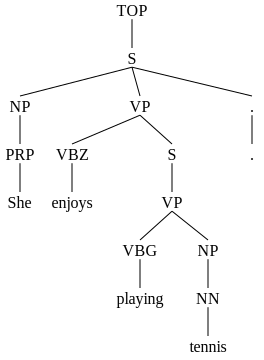

In [ ]:
example_tree = nltk.tree.Tree.fromstring("(TOP (S (NP (PRP She)) (VP (VBZ enjoys) (S (VP (VBG playing) (NP (NN tennis))))) (. .)))")
print(example_tree)
example_tree

The approach in this project is to treat parsing as a span classification task. Each span in the sentence (that is, each combination of start and end position) will be assigned a label. Constituents will be labeled with their syntactic category, while non-constituents will recieve a special null label.

In the tree above, "enjoys playing tennis" will be assigned the label "VP", while "She enjoys playing" will be assigned the null label.

However, there is a slight issue applying this to the tree above: the span "playing tennis" is simultaneously a verb phrase (VP) and a nested clause (S). To resolve this issue, we introduce a special chain label "S+VP" for this situation.

The function `collapse_unary_strip_pos` transforms trees to collapse such unary chains. It also strips part-of-speech labels (which can be predicted by the tagger in the previous part of this project), as well as the root label "TOP".

In [ ]:
def collapse_unary_strip_pos(tree):
  def strip_pos(tree):
    if len(tree) == 1 and isinstance(tree[0], str):
      return tree[0]
    else:
      return nltk.tree.Tree(tree.label(), [strip_pos(child) for child in tree])
  collapsed_tree = strip_pos(tree)
  collapsed_tree.collapse_unary(collapsePOS=True)
  if collapsed_tree.label() == 'TOP' and len(collapsed_tree) == 1:
    collapsed_tree = collapsed_tree[0]
  return collapsed_tree 

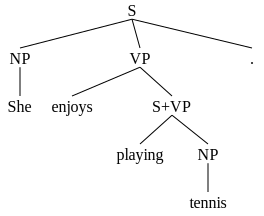

In [ ]:
collapsed_tree = collapse_unary_strip_pos(example_tree)
collapsed_tree

Tree objects behaves like lists, in that they can be indexed to produce child nodes. Calling `.label()` returns its label.  If a child is a word instead of a subtree node, it will be a Python string.

Child 0 is: (NP She)


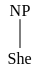

Child 1 is: (VP enjoys (S+VP playing (NP tennis)))


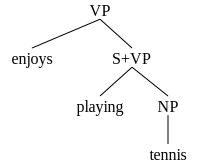

Child 1 label is: VP


In [ ]:
print('Child 0 is:', collapsed_tree[0])
display(collapsed_tree[0])
print('Child 1 is:', collapsed_tree[1])
display(collapsed_tree[1])
print('Child 1 label is:', collapsed_tree[1].label())

We will first implement an `encode_tree` function that maps from Tree objects to sets of spans with labels and starting/end positions. Since we're using a subword tokenization, the span start/end position will be defined in terms of subword positions. The start position is inclusive and the end is exclusive.  (Note that `▁` is considered part of the span of the following word even if it is not attached.)

In [ ]:
print(PARTS_OF_SPEECH)
forbidden_symbols = PARTS_OF_SPEECH[0:8] + [PARTS_OF_SPEECH[-1]]

['#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [ ]:
from collections import deque

def encode_tree(tree):
  """Converts a tree into subword token ids and a list of labeled spans.

  Args:
    tree: an nltk.tree.Tree object

  Returns:
    A tuple (ids, is_word_end, spans)
      ids: a list of token ids in the subword vocabulary
      is_word_end: a list with elements of type bool, where True indicates that
                   the word piece at that position is the last within its word.
      spans: a list of tuples of the form (start, end, label), where `start` is
             the position in ids where the span starts, `end` is the ending
             point in the span (exclusive), and `label` is a string indicating
             the syntactic label for the constituent.
  """

  tree = collapse_unary_strip_pos(tree)
  
  s = ' '.join(tree.leaves())

  ids = []
  word_end_mask = []
  spans = []
  start = 0
  word_pos = [None for _ in range(len(tree.leaves()))]

  cnt = 0
  for subtree in tree.subtrees(): #to identify the already visited branches in the visited array
      subtree.id = cnt
      cnt+=1

  for i,word in enumerate(tree.leaves()):
    word_ids = VOCAB.EncodeAsIds(word)
    ids.extend(word_ids)
    word_pos[i] = [len(word_end_mask), len(word_end_mask) + len(word_ids)]
    word_end_mask.extend([False]*(len(word_ids)-1) + [True])

  #Breadth First Search
  queue = deque()
  visited = []
  output = []
  n = tree
  queue.append([n,0])
  while len(queue) > 0:
    n, counts = queue.popleft()
    if type(n) != str and n.id not in visited and n.label() not in forbidden_symbols:
        visited.append(n.id)
        spans.append((word_pos[counts][0], word_pos[counts+len(n.leaves())-1][1], n.label()))
        
        c=0
        for i in range(len(n)): #we need this to add the number of elements on the left of the future branch in queue
            queue.append([n[i], counts + c])
            if type(n[i]) != str:
                c += len(n[i].leaves())
            else:
                c+=1
        
  return ids, word_end_mask, spans


Now we can take inventory of all span labels in the training data. The validation and test sets have a few span labels outside this set because collapsing unary chains creates additional labels, so we also introduce an `UNK` label. Finally, there is a null label to represent that a span is not a syntactic constituent.

In [ ]:
SPAN_LABELS = set()
for tree in READER.parsed_sents('train'):
  _, _, spans = encode_tree(tree)
  for _, _, label in spans:
    SPAN_LABELS.add(label)
SPAN_LABELS = ['', 'UNK'] + sorted(SPAN_LABELS)


In [ ]:
class ParsingDataset(torch.utils.data.Dataset):
  def __init__(self, split):
    assert split in ('train', 'dev', 'test')
    self.trees = READER.parsed_sents(split)
    if split == 'train':
      # To speed up training, we only train on short sentences.
      self.trees = [tree for tree in self.trees if len(tree.leaves()) <= 40]

  def __len__(self):
    return len(self.trees)

  def __getitem__(self, index):
    """ This function loads a single tree into tensors for 'ids', 'labels', and
    'is_word_end'.

    See 'collate' function below for a description of the batched version of the
    tensors to return.
    """

    tree = self.trees[index]
    

    # use '' (index 0) as the null label for spans that aren't constituents

    ids, is_word_end, spans = encode_tree(tree)
    ids = [BOS_ID] + ids + [EOS_ID] # add BOS_ID and EOS_ID to the start and end of the sentence
    is_word_end = [False] + is_word_end + [False]
    ids = torch.tensor(ids)
    is_word_end = torch.tensor(is_word_end)

    labels = np.zeros((len(ids),len(ids))) #fill every position as null
    for i,j,label in spans:
        if label not in SPAN_LABELS:
            # need to check for unknown labels and replace them with
            # 'UNK' (because of unique unary chains in the validation and test sets)
            labels[i+1,j+1] = SPAN_LABELS.index('UNK')
        else:
            labels[i+1,j+1] = SPAN_LABELS.index(label)
    # need a separate index (-1) for positions that should not
    # receive loss (where end position is before start position)
    for i in range(labels.shape[0]):
        for j in range(0,i+1):
            labels[i,j] = -1
    labels[0,:] = -1*np.ones(labels.shape[1]) #mask spans that contain BOS
    
    labels = torch.tensor(labels, dtype = torch.long)
        
    return {'ids': ids, 'labels': labels, 'is_word_end': is_word_end}

  @staticmethod
  def collate(batch):
    """ This function takes a list of examples as output by your __getitem__
    function and turns them into batched tensors.
    
    Returns:
      A dictionary with three keys.
      * 'ids' holds a tensor of shape [batch_size, max_sentence_length] and
        dtype torch.long (where max length is taken within this batch).
      * 'labels' is a required feature that's used by our evaluation logic. It
        should be a torch.long tensor of shape
        [batch_size, max_sentence_length, max_sentence_length] with
        labels[batch, i, j] representing the label of the span starting at
        subword position i and ending at subword position j (exclusive).
      * 'is_word_end' is a required feature that's used by our skeleton code.
        It should be a torch.bool tensor of shape [batch_size, max_sentence_length],
        with True values at the last sub-word piece for each word.
    """

    ids = pad_sequence(
        [item['ids'] for item in batch],
        batch_first=True, padding_value=PAD_ID)
    is_word_end = pad_sequence(
        [item['is_word_end'] for item in batch],
        batch_first=True, padding_value=False)

    max_sentence_length = is_word_end.shape[1]
    item = batch[0]
    labels = torch.cat([F.pad(item['labels'], pad=(0,max_sentence_length - item['labels'].shape[1], 0, max_sentence_length - item['labels'].shape[0]), value = -1) for item in batch]).view(len(batch), max_sentence_length, max_sentence_length)
    return {
        'ids': ids.to(device),
        'labels': labels.to(device),
        'is_word_end': is_word_end.to(device),
        }


In [ ]:
dataset_for_inspection = ParsingDataset('train')
print(dataset_for_inspection.trees[0].leaves())
dataset_for_inspection[0]

['Ms.', 'Haag', 'plays', 'Elianti', '.']


{'ids': tensor([   1,  126,    4,   14, 9362,  711,    4, 4386, 8675,    7,    2]),
 'is_word_end': tensor([False, False, False,  True,  True, False,  True, False,  True,  True,
         False]),
 'labels': tensor([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1,  0,  0,  0, 32,  0,  0,  0,  0, 67],
         [-1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
         [-1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0],
         [-1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0],
         [-1, -1, -1, -1, -1, -1,  0,  0,  0, 94,  0],
         [-1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0],
         [-1, -1, -1, -1, -1, -1, -1, -1,  0, 32,  0],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])}

## Parsing: Model

Next, we implement a Transformer-based parsing model. Below is a base class that checks performance on the validation set based on a local decision at each span.  Later, we will implement CKY decoding that ensures the output is a tree rather than a set of possibly-intersecting spans.

In [ ]:
class ParsingModel(nn.Module):
  def encode(self, batch):
    # you will override this below
    raise NotImplementedError()

  def compute_loss(self, batch):
    # you will override this below
    raise NotImplementedError()

  def get_validation_metric(self):
    dataset = ParsingDataset('dev')
    data_loader = torch.utils.data.DataLoader(
      dataset, batch_size=8, collate_fn=dataset.collate)
    self.eval()
    total_gold_spans = 0
    total_predicted_spans = 0
    total_correct = 0
    with torch.no_grad():
      for batch in data_loader:
        mask = (batch['labels'] != -1)
        model_output = self.encode(batch)
        predicted_labels = model_output.argmax(-1)
        predicted_labels = predicted_labels[mask]
        gold_labels = batch['labels'][mask]

        total_gold_spans += (gold_labels != 0).sum().item()
        total_predicted_spans += (predicted_labels != 0).sum().item()
        total_correct += ((predicted_labels == gold_labels) & (gold_labels != 0)
            ).sum().item()

    if total_predicted_spans != 0:
      precision = total_correct / total_predicted_spans
    else:
      precision = 0.0
    recall = total_correct / total_gold_spans
    if precision == 0.0 or recall == 0.0:
      f1 = 0.0
    else:
      f1 = 2 * precision * recall / (precision + recall)
    # For convenience, we represent precion/recall/F1 as percentage points.
    precision *= 100
    recall *= 100
    f1 *= 100
    print(f"precision={precision:.2f} recall={recall:.2f} f1={f1:.2f}")
    return f1

The parser should:
- Run a Transformer encoder to produce a vector at each position in the sentence.
- Compute a vector for each span, by subtracting the vectors for the start and endpoints. There are also other options, such as adding, averaging, or concatenating.
- Run an MLP span classifier that takes these span vectors as input. The MLP should have one layer of nonlinearity. The MLP also includes a Layer Normalization step.

In [ ]:
class TransformerParsingModel(ParsingModel):
  def __init__(self):
    super().__init__()
    d_model = 256
    self.add_timing = AddPositionalEncoding(d_model)
    self.encoder = TransformerEncoder(d_model)
    
    self.embedding = nn.Embedding(VOCAB.GetPieceSize(), d_model)
    self.layernorm = nn.LayerNorm(normalized_shape = d_model)

    self.fc1 = nn.Linear(d_model, 512)
    self.fc2 = nn.Linear(512, len(SPAN_LABELS))
    self.layernorm2 = nn.LayerNorm(normalized_shape = len(SPAN_LABELS))

  def encode(self, batch):
    """Returns logits for each label and each span in the sentence.
    
    Returns:
      A float tensor of shape [batch_size, length, length, len(SPAN_LABELS)],
      where the element at position [n, i, j, l] represents the score (logit) of
      assigning label l to the span beginning at subword position i and ending
      at position j (exclusive), for the n-th example in the batch.
    """
    # We don't need to worry about is_word_end here or in compute_loss
    # We can train with non-end subwords still in place (with null labels) and
    # we'll handle adjusting for subwords for you in the evaluation functions
    mask = torch.where(batch['ids'] == PAD_ID, torch.zeros_like(batch['ids'], device = device), torch.ones_like(batch['ids'], device=device))
    x = self.embedding(batch['ids'])
    x = self.add_timing(x)
    x = self.encoder(x, mask) #[batch_size, sentence_length, d_model]

    batch_size = batch['ids'].shape[0]
    max_sentence_length = batch['ids'].shape[1]

    labels = torch.zeros(batch_size, max_sentence_length, max_sentence_length, x.shape[-1], device = device)

    x_aug = x.unsqueeze(1).repeat(1,max_sentence_length, 1, 1)[:,:-1,:-1,:] #[batch_size, sentence_length, sentence_length, d_model] 
    labels[:,:-1,1:,:] =  x_aug.permute(0,2,1,3) - x_aug
    for i in range(1, max_sentence_length - 2):
        labels[:,i,i+1,:]=x[:,i]
    labels = F.relu(self.fc1(labels))
    labels = self.fc2(labels)
    labels = self.layernorm2(labels)
    
    return labels
  
  def compute_loss(self, batch):
    """This function should compute a cross-entropy loss for training the model.

    Note that labels should be set to -1 wherever there is no classification
    decision to make; for example, due to padding or at positions [..., i, j, :]
    where i >= j (i.e. the supposed start position is equal to or comes after
    the end position).
    """
    logits = self.encode(batch)
    labels = batch['labels']

    predictions = logits.view(-1, len(SPAN_LABELS))
    labels = labels.view((-1,))
    return F.cross_entropy(predictions, labels, ignore_index = -1)


The code below trains the parser.

In [ ]:
# You are welcome to adjust these parameters based on your model implementation.
num_epochs = 16
batch_size = 16

parsing_model = TransformerParsingModel().to(device)
train(parsing_model, num_epochs, batch_size, "parsing_model.pt",
      dataset_cls=ParsingDataset)

In [ ]:
parsing_model = TransformerParsingModel().to(device)
parsing_model.load_state_dict(torch.load('parsing_model.pt'))

<All keys matched successfully>

In [ ]:
parsing_model.get_validation_metric()

precision=86.36 recall=85.94 f1=86.15


86.14784380071124

Having trained a parser, it is now time to have it produce trees.

In [ ]:
def predict(parsing_model, split, tagging_model=None):
  assert split in ('dev', 'test')
  if tagging_model is None:
    tagged_sents = READER.tagged_sents(split)
  else:
    tagged_sents = predict_tags(tagging_model, split)
  
  label_scores_charts = predict_span_label_scores(parsing_model, split)

  pred_trees = []
  for tagged_sent, label_scores_chart in zip(tagged_sents, label_scores_charts):
    leaves = [nltk.tree.Tree(tag, [word]) for word, tag in tagged_sent]
    tree = cky_decode(leaves, label_scores_chart)
    tree = uncollapse_tree(tree)
    pred_trees.append(tree)
  return pred_trees


def predict_span_label_scores(parsing_model, split):
  assert split in ('dev', 'test')
  dataset = ParsingDataset(split)
  data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=False, collate_fn=dataset.collate)
  parsing_model.eval()
  all_label_scores_charts = []
  with torch.no_grad():
    for batch in data_loader:
      label_scores_charts = parsing_model.encode(batch)
      for i in range(batch['ids'].shape[0]):
        label_scores_chart = label_scores_charts[i]

        # The data pipeline uses is_word_end for consistency with the part of
        # speech tagging models, but here we need is_word_start instead. Note
        # that because span endpoints use exclusive indexing, the index actually
        # points to the first subword in the next word.
        is_word_end = batch['is_word_end'][i]
        is_word_start = F.pad(is_word_end, (1, -1), value=False)
        is_word_start[1] = True

        # Extract scores for whole words only, ignoring any model decisions that
        # have a span start or end halfway through a word. Evaluation for
        # parsing typically uses the ground-truth tokenization from the dataset.
        label_scores_chart = label_scores_chart[
            is_word_start, : ,:][:, is_word_start, :]
        label_scores_chart = label_scores_chart.cpu().numpy()

        all_label_scores_charts.append(label_scores_chart)
  return all_label_scores_charts


def uncollapse_tree(tree):
  if isinstance(tree, str):
    return tree
  else:
    labels = tree.label().split('+')
    children = []
    for child in tree:
      child = uncollapse_tree(child)
      if isinstance(child, str) and (len(tree) > 1
                                     or labels[-1] not in PARTS_OF_SPEECH):
        child = nltk.tree.Tree('UNK', [child])
      children.append(child)
    for label in labels[::-1]:
      children = [nltk.tree.Tree(label, children)]
    return children[0]

The argmax model predictions are not guaranteed to be a valid tree: some of the spans may intersect with one another, which is not allowed in our syntactic formalism. Now we implement CKY decoding, which will be used to find the highest-scoring tree under the model (i.e. the set of span label assignments with highest probability, among all sets where none of the spans intersect). We won't need to implement special handling for unary chains because we have collapsed all unary chains into a single label. Also, while traditional CKY had to maximize over production rules (between a span label and its children's labels), here we can maximize over span labels independently because we aren't modeling interactions between adjacent labels.

CKY is designed to handle binary trees, but some productions have greater than two children. For this project, we will handle non-binary productions by allowing intermediate dummy nodes with a special null label, implemented in the code as an empty string '' at index 0 in SPAN_LABELS. All non-spans are assigned this label. You should allow your CKY to select spans with the null label, but then collapse them out when creating the tree. For example, to create a trinary production "(A b c d)", CKY would select a tree that looks like "(A b (null c d))" or "(A (null b c) d)" and then would remove the null nodes to get "(A b c d)" like we wanted.

If we allow CKY to select null labels and we directly use log probabilities as the scores, we will often end up with trees made up entirely of null labels. This happens because many spans have a very high probability assigned to the null label (because they clearly shouldn't be a constituent), and choosing a maximum probability tree will be biased towards selecting these. To avoid having high-probability null labels competing with non-null labels, we can normalize our scores in a different way: for each span, we will subtract the score (logit) of the null label from the scores of all the labels (both null and non-null). This will make all null label scores 0, and scale the other label scores of the span appropriately. This normalization will make it so that if a local span decision would prefer a non-null label it will have positive score, and thus have higher score than all 0-score null labels. That way, we will prefer to use spans with non-null labels unless they conflict with eachother.

No matter what kind of normalization we do, the local decision of what label would be assigned to a span if it is selected does not change.  The reason we are normalizing is to help CKY decide between different spans when deciding which to include in the final output.

It is possible for the tree to have labels on spans of length 1. These labels will go directly above the part of speech label. E.g. the example tree at the beginning of "Parsing: Setup" has a NP span label directly above the NN part-of-speech label.

Could we use i->i+1 instead of the POS output ? Yes, part of the reason we do things differently for part of speech tagging and parsing is that sometimes people only want to work on or use part of speech tags, so it made sense to have a separate task for it.  Also, in the pre-neural era the types of models people used for part of speech tagging and parsing were much less similar.


In [ ]:
def cky_decode(leaves, label_scores_chart):
  """
  leaves contains the n terminal words
  label_scores_chart has (n+1)*(n+1)*V shape
  """
  #by independence assumption, we can take the max and argmax of each cell
  scores = F.log_softmax(torch.tensor(label_scores_chart), dim=-1)
  scores = scores - scores[:,:,0].unsqueeze(2).repeat(1,1,scores.shape[2]) #null index
  max_ = scores.max(-1)
  scores = max_.values.cpu().numpy()
  tags = max_.indices.cpu().numpy()
  
  #table of trees: table[i,j] = most probable tree from i to j exluded + score
  #Fill the table for single words and two words:
  table = [[None for _ in range(scores.shape[1])] for _ in range(scores.shape[0])]
  for i in range(0,len(table)-1):
      #i -> i+1
      table[i][i+1] = (nltk.tree.Tree(SPAN_LABELS[tags[i,i+1]], [leaves[i]]), scores[i,i+1])
      #i -> i+2
      if i < len(table) - 2:
        children = []
        if tags[i,i+1] == 0: #null label
            children.append(leaves[i])
        else:
            children.append(nltk.tree.Tree(SPAN_LABELS[tags[i,i+1]], [leaves[i]]))
        if tags[i+1,i+2] == 0:
            children.append(leaves[i+1])
        else:
            children.append(nltk.tree.Tree(SPAN_LABELS[tags[i+1,i+2]], [leaves[i+1]]))
        score = scores[i,i+1]+scores[i+1,i+2]+scores[i,i+2]
        table[i][i+2] = (nltk.tree.Tree(SPAN_LABELS[tags[i,i+2]], children), score)

  def select_tree(table, i,j):
      """
      selects the best tree between word i and word j (excluded)
      """
      assert i < j

      if table[i][j] != None:
          return table[i][j]
      else:
          scores_ = []
          for k in range(i+1,j):
              table[i][k] = select_tree(table, i, k)
              table[k][j] = select_tree(table, k, j)

              scores_.append(table[i][k][1] + table[k][j][1] + scores[i,j])
          idx = np.argmax(scores_)
          children = []

          if table[i][i+1+idx][0].label() == '':
              children = children + table[i][i+1+idx][0][:]
          else:
              children.append(table[i][i+1+idx][0])
          if table[i+1+idx][j][0].label() == '':
              children = children + table[i+1+idx][j][0][:]
          else:
              children.append(table[i+1+idx][j][0])

          table[i][j] = (nltk.tree.Tree(SPAN_LABELS[tags[i,j]], children), scores_[idx]) 
          return table[i][j]

  best_tree, best_score = select_tree(table, 0, len(leaves))
                
  return best_tree

The code below runs the parser on the validation data and displays one of the trees.

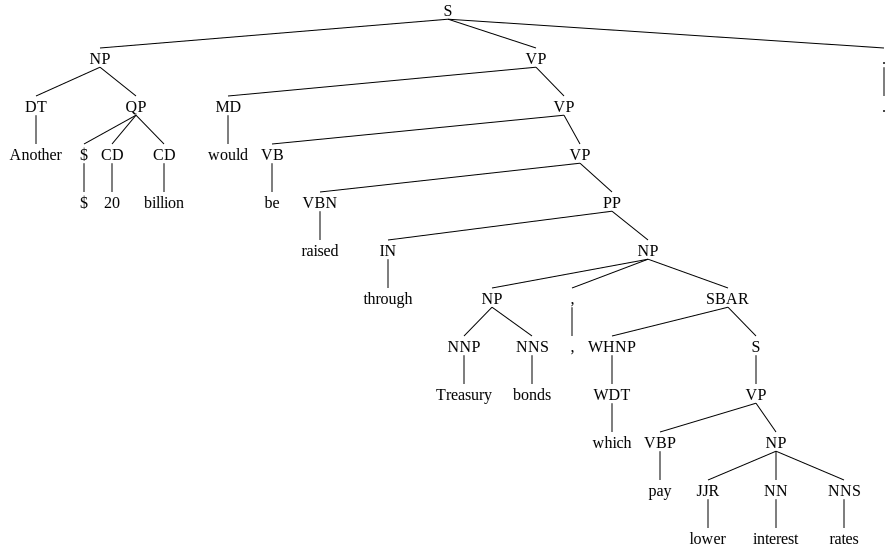

In [ ]:
predicted_dev_trees = predict(parsing_model, 'dev')
predicted_dev_trees[6]

## Final evaluation

The standard evaluation for parsing is typically performed using the EVALB software (https://nlp.cs.nyu.edu/evalb/). The F1 score it reports is slightly different than what we reported during training. For one, this score is computed over original spans, without collapsing unary chains. For a constituent to be considered correct, its label must match the ground-truth label. EVALB also ignores punctuation when determining whether spans are correct.

The metrics reported by EVALB include:
- *Bracketing Recall*: Number of correct constituents divided by the number of constituents in the ground-truth data
- *Bracketing Precision*: Number of correct constituents divided by the number of constituents in the predicted trees
- *Bracketing FMeasure*: The F1 score, which is the harmonic mean of the Bracketing Recall and Bracketing Precision
- *Complete Match*: Percentage of sentences where recall and precision are both 100%
- *Average crossing*: Number of constituents crossing a ground-truth constituent divided by the number of sentences
- *No crossing*: Percentage of sentences which have 0 crossing brackets

Metrics are reported both for the full dataset and for the subset of sentences that have length 40 or shorter.

In the interest of speed, the code in this project only trains on short sentences, and our recommended hyperparameters keep the model size small. Relaxing these restrictions and training for about a day can give better results, possibly as high as 92 F1 on sentences of all lengths.

In [ ]:
# We first need to compile the EVALB program
!cd EVALB
!make &> /dev/null

In [ ]:
with open('./dev_predictions_parser_only.txt', 'w') as f:
  for tree in predicted_dev_trees:
    f.write(' '.join(str(tree).split()) + '\n')

In [ ]:
!cd EVALB; make &> /dev/null

In [ ]:
!EVALB/evalb -p EVALB/nk.prm dev dev_predictions_parser_only.txt | tail -n 29

=== Summary ===

-- All --
Number of sentence        =   1700
Number of Error sentence  =      0
Number of Skip  sentence  =      0
Number of Valid sentence  =   1700
Bracketing Recall         =  86.31
Bracketing Precision      =  89.35
Bracketing FMeasure       =  87.80
Complete match            =  31.00
Average crossing          =   0.78
No crossing               =  69.59
2 or less crossing        =  90.06
Tagging accuracy          = 100.00

-- len<=40 --
Number of sentence        =   1578
Number of Error sentence  =      0
Number of Skip  sentence  =      0
Number of Valid sentence  =   1578
Bracketing Recall         =  88.70
Bracketing Precision      =  90.82
Bracketing FMeasure       =  89.75
Complete match            =  33.27
Average crossing          =   0.55
No crossing               =  73.13
2 or less crossing        =  92.84
Tagging accuracy          = 100.00
